In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load processed data
df = pd.read_csv('../data/processed/processed_reviews.csv')

# Use only 5,000 samples for faster training
df = df.sample(n=5000, random_state=42).reset_index(drop=True)

print(f"✅ Using {len(df)} samples for training.")
df.head()

✅ Using 5000 samples for training.


,processed_review,sentiment
0,really liked summerslam due look arena curtain...,positive
1,many television show appeal quite many differe...,positive
2,film quickly get major chase scene ever increa...,negative
3,jane austen would definitely approve onegwynet...,positive
4,expectation somewhat high went see movie thoug...,negative


In [5]:
# Features and labels
X = df['processed_review']
y = df['sentiment']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# TF-IDF vectorization
print("🔄 Applying TF-IDF...")
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=2, max_df=0.95)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"✅ TF-IDF Matrix Shape: {X_train_tfidf.shape}")

🔄 Applying TF-IDF...
✅ TF-IDF Matrix Shape: (4000, 10000)


In [6]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42)
}

results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n🔁 Training: {name}")
    model.fit(X_train_tfidf, y_train)
    trained_models[name] = model

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    y_pred = model.predict(X_test_tfidf)
    test_acc = accuracy_score(y_test, y_pred)

    results[name] = {
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test Accuracy': test_acc
    }

    print(f"✅ {name} → CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}, Test: {test_acc:.4f}")


🔁 Training: Logistic Regression
✅ Logistic Regression → CV: 0.8483 ± 0.0103, Test: 0.8530

🔁 Training: Naive Bayes
✅ Naive Bayes → CV: 0.8450 ± 0.0076, Test: 0.8490

🔁 Training: Random Forest
✅ Random Forest → CV: 0.8205 ± 0.0098, Test: 0.8390

🔁 Training: SVM
✅ SVM → CV: 0.8460 ± 0.0102, Test: 0.8510


In [7]:
# Convert to DataFrame for display
results_df = pd.DataFrame(results).T.sort_values(by='Test Accuracy', ascending=False)
results_df.style.background_gradient(cmap='Blues')

,CV Mean,CV Std,Test Accuracy
Logistic Regression,0.848250,0.010296,0.853000
SVM,0.846000,0.010167,0.851000
Naive Bayes,0.845000,0.007624,0.849000
Random Forest,0.820500,0.009830,0.839000


✅ Best Model: Logistic Regression


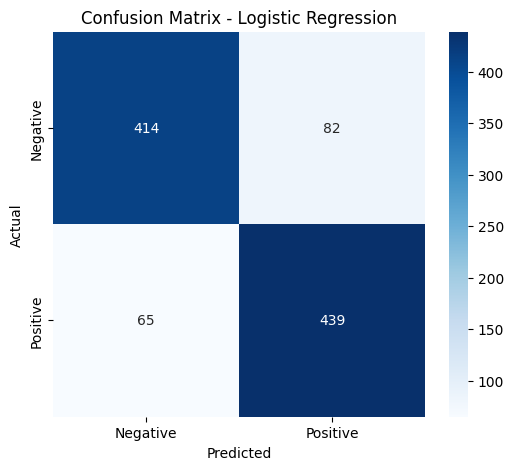

📊 Classification Report:

              precision    recall  f1-score   support

    negative       0.86      0.83      0.85       496
    positive       0.84      0.87      0.86       504

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



In [9]:
# Choose best model (by test accuracy)
best_model_name = results_df.index[0]
best_model = trained_models[best_model_name]

print(f"✅ Best Model: {best_model_name}")

# Predict on test set
y_pred = best_model.predict(X_test_tfidf)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

# Classification report
print("📊 Classification Report:\n")
print(classification_report(y_test,y_pred ))

In [10]:
# Save model and vectorizer
joblib.dump(best_model, '../models/best_model.pkl')
joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')

print("💾 Model and vectorizer saved to '../models/'")


💾 Model and vectorizer saved to '../models/'
